In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Exploratory Data Analysis

Target Class Distribution

In [6]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

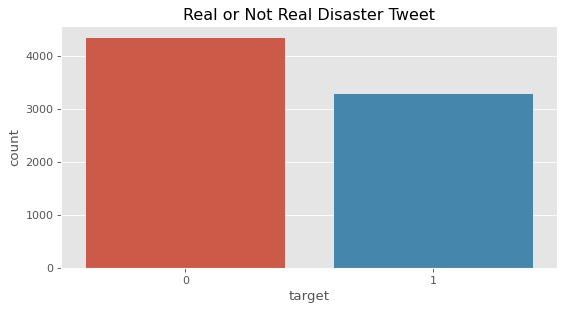

In [7]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [8]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

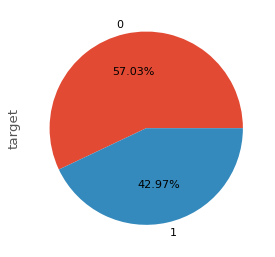

In [9]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

Number of Characters Distribution in Tweets

In [10]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-36r3fw5w
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-36r3fw5w
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11743 sha256=2091b2a0bd03bde1f3185fb0d46277442b327df3626f5438b7303e9cb0ef1617
  Stored in directory: /tmp/pip-ephem-wheel-cache-zjz9x0um/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [11]:
import preprocess_kgptalkie as kgp

In [12]:
tweet = kgp.get_basic_features(tweet)

In [13]:
tweet = kgp.get_basic_features(tweet)

In [14]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


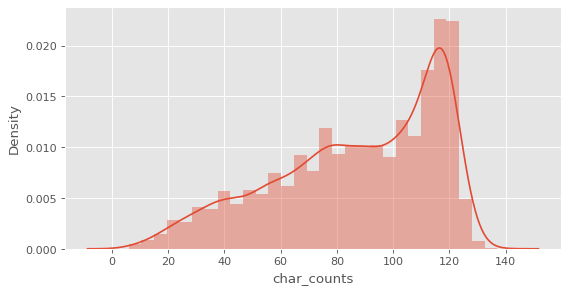

In [15]:
sns.distplot(tweet['char_counts'])

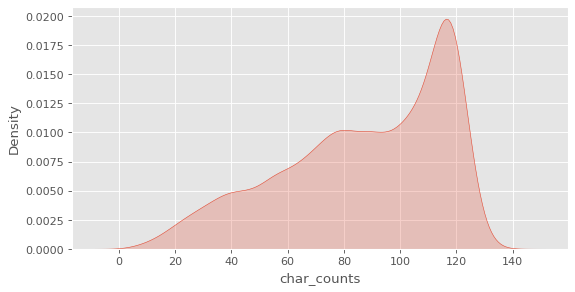

In [16]:
sns.kdeplot(tweet['char_counts'], shade=True)

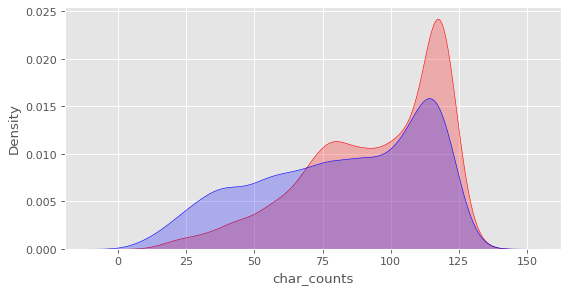

In [17]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

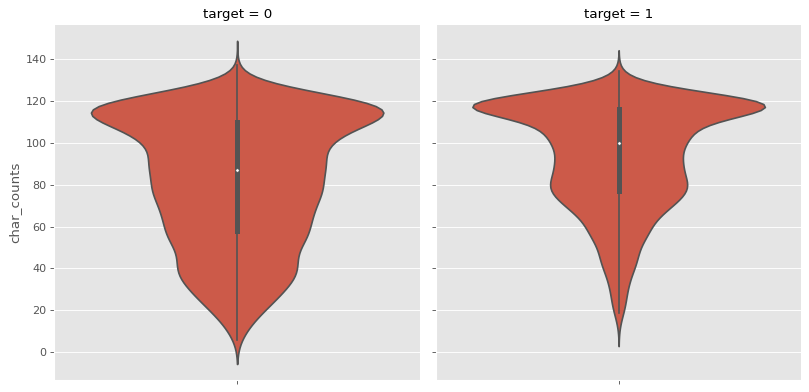

In [18]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

Number of Words, Average Words Length, and Stop words Distribution in Tweets

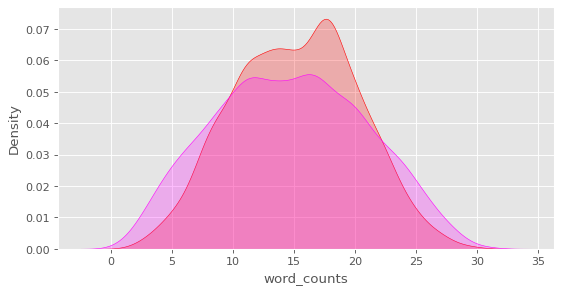

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


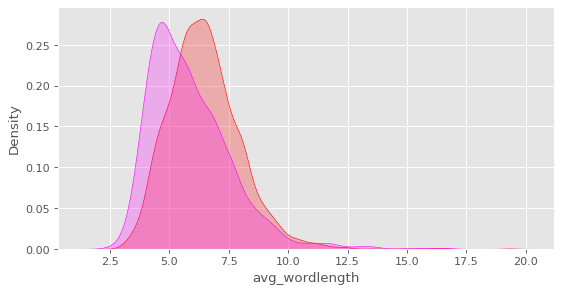

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


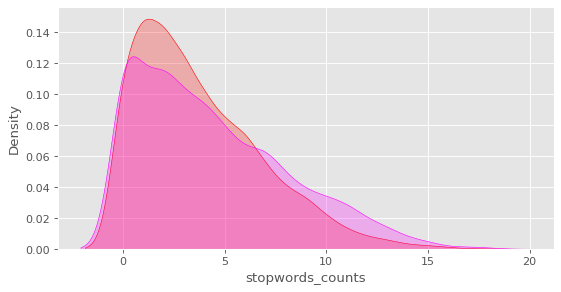

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [22]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

Most and Least Common Words


In [23]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [24]:
top20 = freqs[100:120]

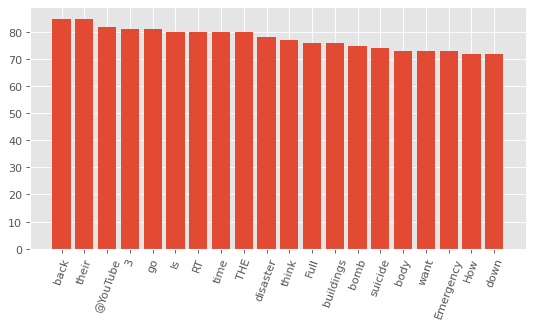

In [25]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [26]:
least20 = freqs[-20:]
least20

incessant                 1
public:                   1
(Ft.                      1
Cats                      1
http://t.co/YmY4rSkQ3d    1
'light                    1
dolla                     1
chaos'                    1
#MakeWaterWork            1
@NathanFillion            1
Mallord                   1
hail.                     1
TodayÛªs                 1
#canpoli                  1
Citrus                    1
sanction                  1
http://t.co/vf6CKLmCSX    1
http://t.co/4C58oOaVhY    1
http://t.co/NzqwTCYidv    1
Blamed:                   1
dtype: int64

In [27]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [28]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

One-Shot Data Cleaning

In [29]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [30]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [31]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Disaster Words Visualization with Word Cloud¶

In [32]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via disaster an were be people california suicide has no police who but when been like killed do 2 will hiroshima just so than fires out storm crash families we train about now into s emergency your buildings bomb all there mh370 two what nuclear they am attack video wildfire accident get new bombing one how burning northern minister prime dead legionnaires me bomber some if homes car war atomic still obama he fatal years off collapse us may forest retweet watch city debris malaysia first 1 today japan mass man latest or severe water near had those earthquake confirmed before found would oil floods world spill down army 70 under home warning outbreak weather wreckage derailment injured could 4 3 evacuation thunderstorm 40 saudi being migrants old our missing investigators flood flooding say during can their bridge time death state her mosque back suspect kil

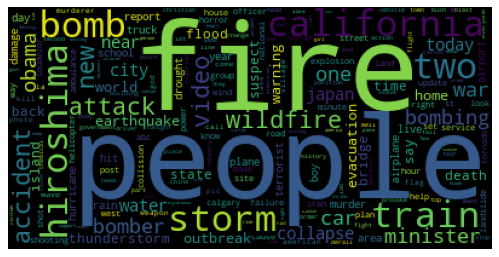

In [33]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

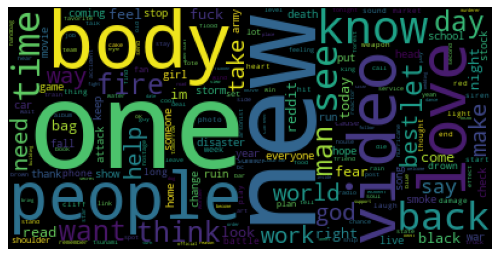

In [34]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Classification with TFIDF and SVM

In [35]:
text = tweet['text']
y = tweet['target']

In [36]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [37]:
X.shape

(7613, 22545)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [39]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [40]:
from sklearn.svm import LinearSVC

In [41]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



Classification with Word2Vec and SVM

In [42]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=355c4faa8d0fc788e8e512b4796f8f3ce05252452878b58e9a9e814698fd16da
  Stored in directory: /tmp/pip-ephem-wheel-cache-ramz_azv/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [43]:
import spacy
import en_core_web_lg

In [44]:
nlp = en_core_web_lg.load()

In [45]:
x = 'cat dog'
doc = nlp(x)

In [46]:
doc.vector.shape

(300,)

In [47]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [48]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [49]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [50]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [51]:
X.shape

(7613, 1)

In [52]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [53]:
X.shape

(7613, 300)

In [54]:
y = tweet['target']

In [55]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

CPU times: user 43.2 ms, sys: 1e+03 ns, total: 43.2 ms
Wall time: 45 ms


Word Embeddings and Classification with Deep Learning

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [57]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [58]:
token = Tokenizer()
token.fit_on_texts(text)

In [59]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [60]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [61]:
encoded_text = token.texts_to_sequences(text)

In [62]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [63]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [64]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [65]:
X.shape

(7613, 40)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [67]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.37      0.45       869
           1       0.44      0.66      0.53       654

    accuracy                           0.49      1523
   macro avg       0.51      0.51      0.49      1523
weighted avg       0.52      0.49      0.48      1523

CPU times: user 671 ms, sys: 7.97 ms, total: 679 ms
Wall time: 687 ms


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [68]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2258100   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [70]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 9s 39ms/step - loss: 0.6723 - accuracy: 0.5745 - val_loss: 0.5814 - val_accuracy: 0.7387
Epoch 2/5
191/191 [==============================] - 7s 37ms/step - loss: 0.5028 - accuracy: 0.7895 - val_loss: 0.4655 - val_accuracy: 0.7794
Epoch 3/5
191/191 [==============================] - 7s 37ms/step - loss: 0.3180 - accuracy: 0.8771 - val_loss: 0.4708 - val_accuracy: 0.7886
Epoch 4/5
191/191 [==============================] - 7s 36ms/step - loss: 0.2001 - accuracy: 0.9343 - val_loss: 0.5297 - val_accuracy: 0.7748
Epoch 5/5
191/191 [==============================] - 7s 36ms/step - loss: 0.1244 - accuracy: 0.9556 - val_loss: 0.6008 - val_accuracy: 0.7301
CPU times: user 58.8 s, sys: 2.5 s, total: 1min 1s
Wall time: 36.7 s


In [71]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [72]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [73]:
vec

array([[  7,  31,   5, 103,  20,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [74]:
np.argmax(model.predict(vec), axis = -1)

array([0])